In [64]:
import pandas as pd
import numpy as np
import cv2, os
import scipy
from scipy import signal
import csv
import matplotlib.pyplot as plt

In [65]:
circle_color, line_color = (255,255,0), (0,0,255)
window_length, polyorder = 15, 3


In [74]:
cap = cv2.VideoCapture('/home/suprnrdy/workspace/weightlift/weightlift-trim.mp4')
## some videowriter props
sz = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
out = cv2.VideoWriter('/home/suprnrdy/workspace/weightlift/smooth_pose_skeleton.avi',
                      cv2.VideoWriter_fourcc('M','J','P','G'), 30, sz)

In [67]:
# This converts the flattened dataframe back to (n,25,3) array with n being the number of 
# frames, 25 being the pose points, and 3 being x,y,probability for each pose joint.
# Get pose data - data is generated by OpenPose
df = pd.read_csv('/home/suprnrdy/workspace/weightlift/cleanandjerk.csv')
posedata = np.array(df.values.reshape(df.shape[0],25,3))
posedata.shape

(1305, 25, 3)

In [68]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,268.629242,146.692337,0.903268,339.974487,242.581085,0.768271,298.257446,244.255966,0.798398,301.761566,...,0.148456,298.246552,583.777405,0.489597,299.932800,578.593933,0.448608,397.553467,564.626160,0.445479
1,268.664062,145.046204,0.904204,339.973175,242.562088,0.766197,298.259491,244.226593,0.798119,301.734375,...,0.147836,298.247589,583.772644,0.483101,299.933472,578.594727,0.441915,397.560425,564.618652,0.446252
2,270.280884,145.004288,0.912309,339.967926,242.526230,0.760687,298.252686,244.210571,0.799152,301.735138,...,0.145986,298.251709,583.775391,0.482812,299.934662,578.593079,0.441772,397.557922,564.600159,0.458429
3,270.340424,144.923492,0.907471,339.977051,242.550507,0.765996,298.254791,244.193161,0.798388,301.754089,...,0.145027,298.236145,583.770752,0.483230,298.273773,578.608948,0.444314,397.530884,562.867310,0.481085
4,270.396088,143.289993,0.905794,339.989227,242.566101,0.766802,298.263855,242.564377,0.797888,301.765503,...,0.145475,298.219849,583.772400,0.493106,298.266083,578.609802,0.454859,397.492310,562.895447,0.484242


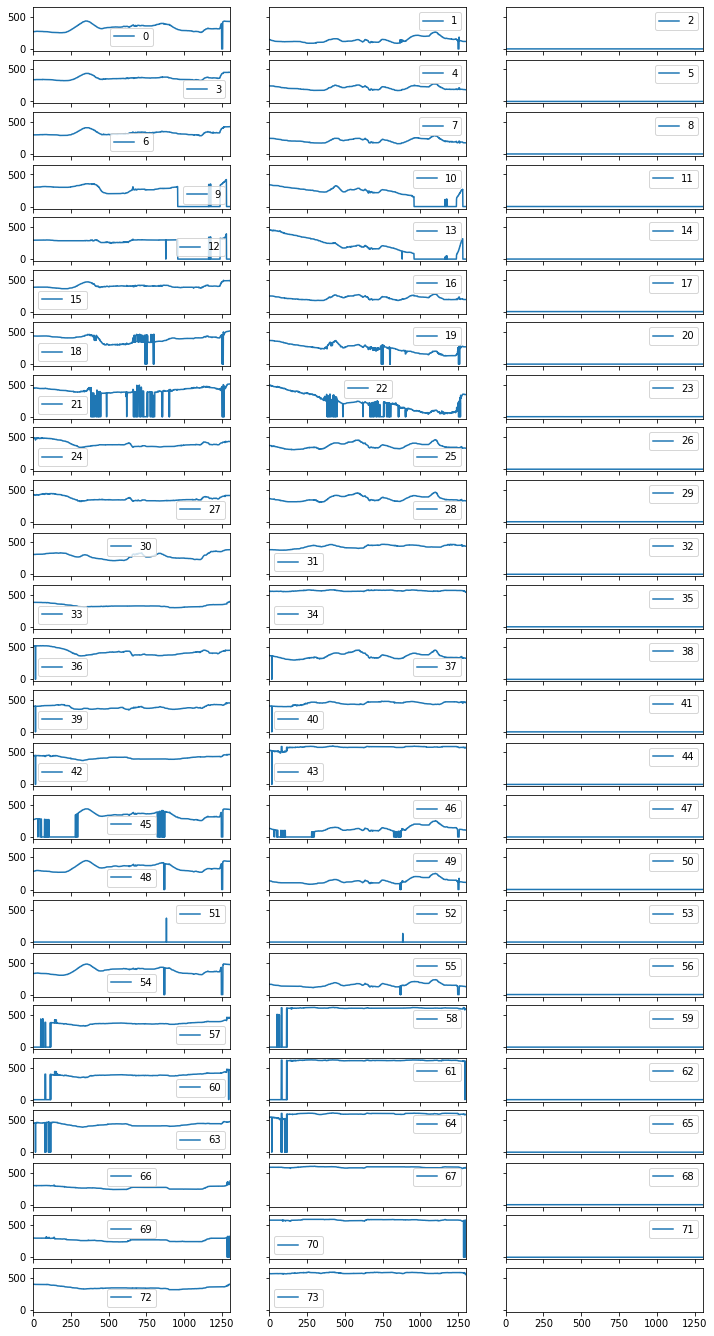

In [69]:
fig,axes = plt.subplots(nrows=25, ncols=3, sharex=True, sharey=True, figsize=(12,24))
r = 0
c = 0
for col in (df.index):
    if col is 74:
        break
    df.plot(kind='line', y=col, ax=axes[r][c])
    r = int((col+1)/3)
    c = (col+1)%3

In [70]:
df2 = df.copy()
for i in range(74): df2[str(i)] = signal.savgol_filter(df2[str(i)], window_length, polyorder)


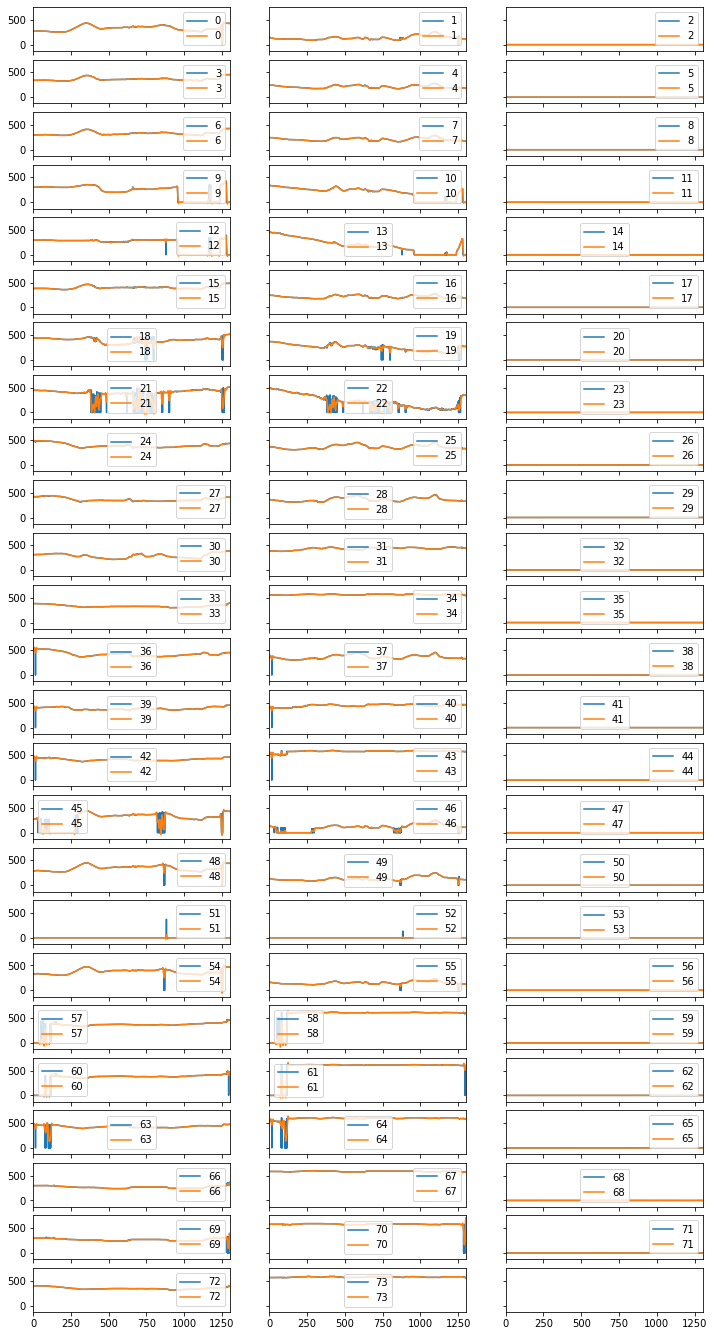

In [71]:
fig,axes = plt.subplots(nrows=25, ncols=3, sharex=True, sharey=True, figsize=(12,24))
r = 0
c = 0
for col in (df.index):
    if col is 74:
        break
    df.plot(kind='line', y=col, ax=axes[r][c])
    df2.plot(kind='line', y=col, ax=axes[r][c])
    r = int((col+1)/3)
    c = (col+1)%3

In [72]:
# //     {0,  "Nose"},
# //     {1,  "Neck"},
# //     {2,  "RShoulder"},
# //     {3,  "RElbow"},
# //     {4,  "RWrist"},
# //     {5,  "LShoulder"},
# //     {6,  "LElbow"},
# //     {7,  "LWrist"},
# //     {8,  "MidHip"},
# //     {9,  "RHip"},
# //     {10, "RKnee"},
# //     {11, "RAnkle"},
# //     {12, "LHip"},
# //     {13, "LKnee"},
# //     {14, "LAnkle"},
# //     {15, "REye"},
# //     {16, "LEye"},
# //     {17, "REar"},
# //     {18, "LEar"},
# //     {19, "LBigToe"},
# //     {20, "LSmallToe"},
# //     {21, "LHeel"},
# //     {22, "RBigToe"},
# //     {23, "RSmallToe"},
# //     {24, "RHeel"},
# //     {25, "Background"}
# OLD PAIRING There are 15 points in the skeleton
# pairs = [[0,1], # head
#          [1,2],[1,5], # sholders
#          [2,3],[3,4],[5,6],[6,7], # arms
#          [1,14],[14,11],[14,8], # hips
#          [8,9],[9,10],[11,12],[12,13]] # legs

# NEW PAIRING There are 26 points in the skeleton
pairs = [[17,15],[15,0],[16,0],[16,18], #head
         [0,1], #neck
         [1,2],[1,5], #shoulders
         [2,3],[3,4],[5,6],[6,7], #arms
         [1,8], #core
         [8,9],[8,12], #hips
         [9,10],[10,11],[11,22],[11,24],[22,23], #leftleg
         [12,13],[13,14],[14,19],[14,21],[19,20] #rightleg
        ]

In [75]:
cap = cv2.VideoCapture('/home/suprnrdy/workspace/weightlift/weightlift-trim.mp4')

plt.ion()
frame_number = 0
while True:
    ret, img = cap.read()
    blank_image = np.zeros((sz[0],sz[1],3), np.uint8)
    if not ret: break
#     print(frame_number)
    values = np.array(df.values[frame_number], int)

    # We create a list of tuples [(x,y),(x,y),(x,y),etc..]
    points = []                            
    points = list(zip(values[::3], values[1::3]))
    
    cc = 0
    # draw our joints
    for point in points:
        cc += 90
        xy = tuple(np.array([point[0], point[1]], int))
        if xy != [0,0]:
            cv2.circle(blank_image, xy, 5, (cc,cc,cc), 5)
    
    # draw skeleton
    for pair in pairs:
        partA = pair[0]
        partB = pair[1]
        if points[partA] != (0,0) and points[partB] != (0,0): 
            cv2.line(blank_image, points[partA], points[partB], line_color, 3, lineType=cv2.LINE_AA)
    
    # Display the image and write the file.
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.show()
#     k = cv2.waitKey(100)
#     if k == 27: break
    out.write(blank_image)
    frame_number +=1
    
# Close the captures and output files
cap.release()
out.release()